In [41]:
import numpy as np
import matplotlib.pyplot as plt
import metrics
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sneiaTools import metrics
from sklearn.preprocessing import MinMaxScaler

In [31]:
# Number of samples
N = 10000

"""
Generate a sine wave

Generates an array of N parts starting at 0 and ending at 10π.
Calculates the sine of each element of the array t to eventually compare it with the original values 
and use the same original values as a time scale for the plot.
"""
t = np.linspace(0, 10*np.pi, N)
original_signal = np.sin(t)

"""
Contaminate signal

In the noise variable an array of size N is stored where all values rotate around 0 with a standard deviation 
of 0.5. To contaminate the signal, the noise is added to each value of the sine signal.
"""
noise = np.random.normal(0, 0.5, N)
contaminated_signal = original_signal + noise

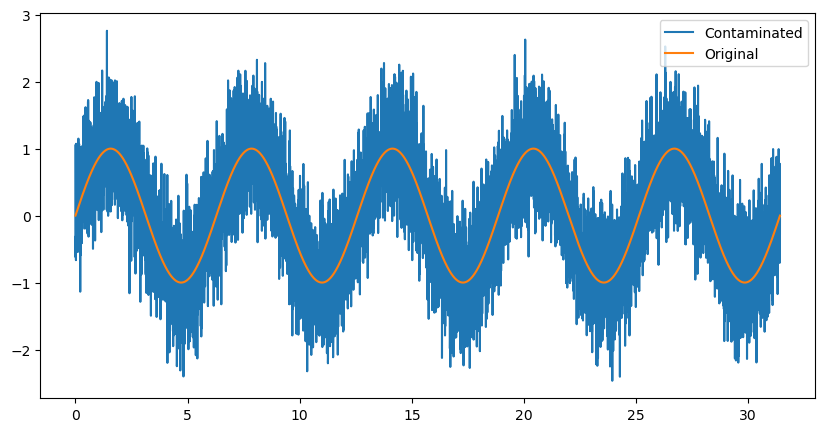

In [32]:
# Plot the original and the contaminated signals
plt.figure(figsize=(10,5))
plt.plot(t, contaminated_signal, label="Contaminated")
plt.plot(t, original_signal, label="Original")
plt.legend()
plt.show()


In [33]:
def create_sequences(input_data, output_data, seq_length):
    """
    This function creates sequences of input_data and the corresponding output_data.
    
    :param input_data: The contaminated signal, a list or 1D array.
    :param output_data: The original clean signal, a list or 1D array.
    :param seq_length: The length of the sequences to be created.
    :return: A tuple (xs, ys), where xs is a list of input sequences, and ys is a list of corresponding output values.
    """
    
    # Initialize lists to hold input sequences and corresponding output values
    xs, ys = [], []
    
    # Iterate over input_data to create sequences of length seq_length
    for i in range( len( input_data ) - seq_length ):
        
        # Creates a list of size 'seq_length' with data immediately following that of the last iteration
        x = input_data[i:(i+seq_length)]
        
        # Creates an integer that matches the list stored in x
        y = output_data[i+seq_length]
        
        # Attach the list and the integer respectively
        xs.append(x)
        ys.append(y)
        
    # Returns a 2-dimensional array in xs and a 1-dimensional array in ys 
    return np.array(xs), np.array(ys)

seq_length = 75
x, y = create_sequences(contaminated_signal, original_signal, seq_length)
"""
In x is stored the matrix with the sequences of contaminated data 
and in y is stored the clean data in the form of a list.
"""

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# A reshape must be made to the data that will eventually be the input of the LSTM since it 
# expects a 3D array and what we have so far is a 2D array.

# To create this new dimension we are going to use the 2D array characteristics themselfs
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

"""
Having done this process we simply added a new bracket around each data in the array, 
this is necessary so that the model can intuit some data it needs about the dataset 
I am going to pass it which are (batch_size, timesteps, features).
"""


'\nHaving done this process we simply added a new bracket around each data in the array, \nthis is necessary so that the model can intuit some data it needs about the dataset \nI am going to pass it which are (batch_size, timesteps, features).\n'

In [36]:
# Data Normalization

# This 'scaler' object is the same with which the data delivered to the model 
# must be normalized when it has been deployed.

# INPUT (3D ARRAY)
# Since the x-array is a 2D array, a small conversion must be made before normalizing it.
x_train_2d = x_train.reshape(-1, x_train.shape[-1])
x_test_2d = x_test.reshape(-1, x_test.shape[-1])

scaler_input = MinMaxScaler(feature_range=(0, 1))
scaler_input.fit(x_train_2d)

x_train_scaled = scaler_input.transform(x_train_2d)
x_test_scaled = scaler_input.transform(x_test_2d)

# We now return the data to its 3D state before continuing
x_train = x_train_scaled.reshape(x_train.shape)
x_test = x_test_scaled.reshape(x_test.shape)


# OUTPUT (1D ARRAY)
# Since the y-array is a 1D array, a small conversion must be made before normalizing it.
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

scaler_output = MinMaxScaler(feature_range=(0, 1))
scaler_output.fit(y_train)

y_train_scaled = scaler_output.transform(y_train)
y_test_scaled = scaler_output.transform(y_test)

# We now return the data to its 1D state before continuing
y_train = y_train_scaled.flatten()
y_test = y_test_scaled.flatten()


In [40]:
"""
Variables to take into account when testing the model:
    - Sequence length
    - Number of LSTM layers
    - Dropout (Only if overfitting occurs)
    - Hyperparameters (Learning rate, batch size, epochs)

"""

model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (seq_length, 1)))

model.add(LSTM(50, return_sequences = False))

model.add(Dense(30, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=Adam())


Epoch 1/50
125/125 [==============================] - 13s 75ms/step - loss: 0.0272 - val_loss: 0.0023 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 8s 67ms/step - loss: 0.0019 - val_loss: 0.0019 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 8s 67ms/step - loss: 0.0019 - val_loss: 0.0017 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 8s 68ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 8s 67ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 9s 69ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/50
125/125 [==============================] - 9s 69ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 8/50
125/125 [==============================] - 9s 69ms/step - loss: 0.0018 - val_loss: 0.0015 - lr: 0.0010
Epoch 9/50
125/125 [==============================] - 9s 69ms/step - loss: 0.0017 - val

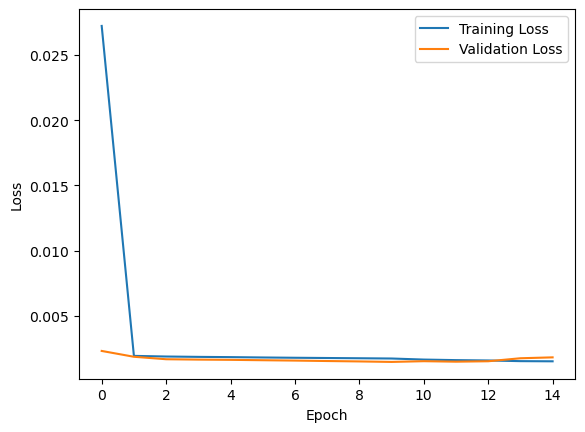

In [42]:
# Training and model validity analysis

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
model_checkpoint = ModelCheckpoint('sin_LSTM.h5', monitor = 'val_loss', save_best_only = True)

# Define Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    x_train,
    y_train,
    epochs = 50,
    validation_data = (x_test, y_test),
    shuffle = False,
    batch_size = 64,
    callbacks = [early_stopping, model_checkpoint, lr_scheduler]
    
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model test

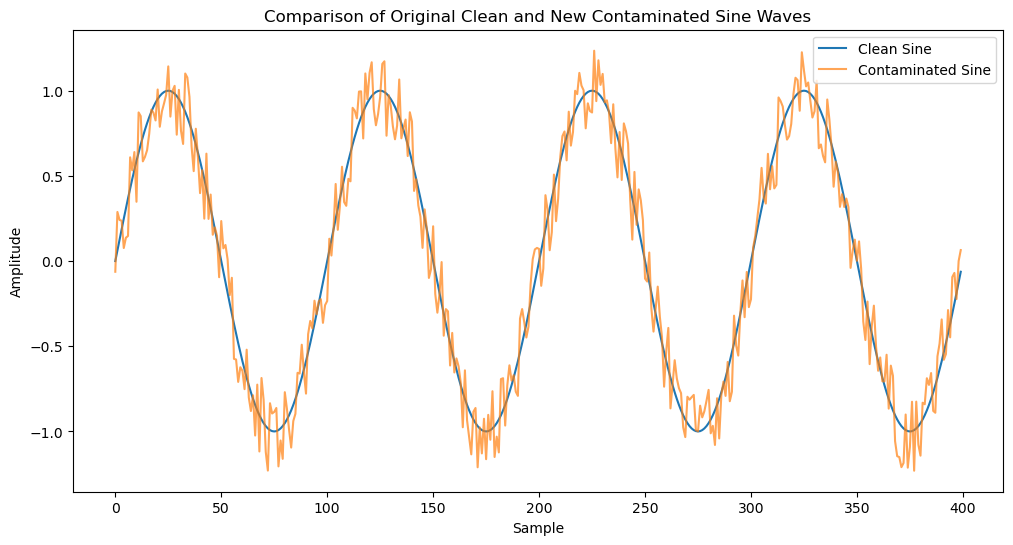

In [44]:
# Create a clean sine wave
frequency = 1  # Frequency of the sine wave
sample_rate = 100  # Sample rate
duration = 4  # seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)  # Time array
clean_sine = np.sin(2 * np.pi * frequency * t)  # Clean sine wave

# Contaminate the sine wave with uniform noise
np.random.seed(42)  # For reproducibility
noise_level = 0.5  # Adjust the noise level
uniform_noise = noise_level * (np.random.uniform(0, 1, clean_sine.shape) - 0.5)  # Uniform noise between [-0.5*noise_level, 0.5*noise_level]
contaminated_sine = clean_sine + uniform_noise  # Contaminated sine wave

plt.figure(figsize=(12,6))
plt.plot(clean_sine, label='Clean Sine')
plt.plot(contaminated_sine, label='Contaminated Sine', alpha=0.7)
plt.title('Comparison of Original Clean and New Contaminated Sine Waves')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


## Preprocess test data

In [45]:
# Convert the dataset to be tested into sequences
def create_test_sequences(input_data, seq_length):
    sequences = [input_data[i:i + seq_length] for i in range(len(input_data) - seq_length)]
    return np.array(sequences)

sin_sequence = create_test_sequences(contaminated_sine.reshape(-1, 1), seq_length)

sin_sequence_normalized = scaler_input.transform(sin_sequence.reshape(-1, 1)).reshape(sin_sequence.shape)

## Clean data

In [46]:
cleaned_sine_scaled = model.predict(sin_sequence_normalized)

cleaned_sine = scaler_output.inverse_transform(cleaned_sine_scaled).flatten()

11/11 [==============================] - 1s 16ms/step


## Check Results

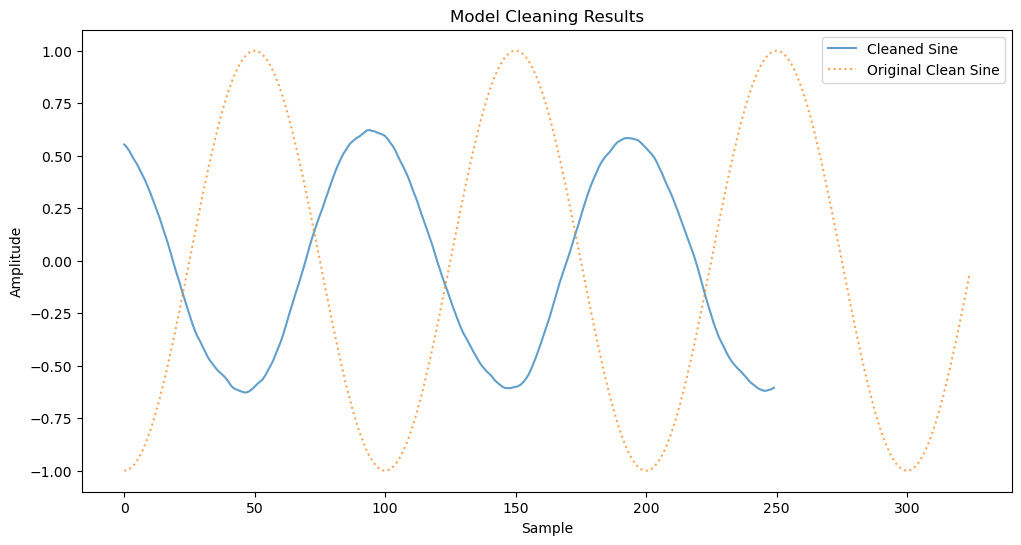

In [49]:
plt.figure(figsize=(12,6))
# plt.plot(contaminated_sine[seq_length:], label='Contaminated Sine')
plt.plot(cleaned_sine[seq_length:], label='Cleaned Sine', alpha=0.7)
plt.plot(clean_sine[seq_length:], label='Original Clean Sine', alpha=0.7, linestyle = 'dotted')
plt.legend()
plt.title('Model Cleaning Results')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()